In [1]:
import torch
#torch.cuda.empty_cache()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#torch.cuda.memory_summary(device=None, abbreviated=False)
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch


/Users/moiz.ali/miniconda3/envs/exist2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(device)

mps


## Get the disagreement exist ids

In [3]:
# loading the subset data

import os
import pandas as pd

subset_folder = "subsets_trial5"
csv_files = [f for f in os.listdir(subset_folder) if f.endswith('.csv')]

dfs = []
for file in csv_files:
    file_path = os.path.join(subset_folder, file)
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        print(f"⚠️ UTF-8 failed for {file}, trying ISO-8859-1...")
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.loc[:, ~df_all.columns.str.startswith('Unnamed:')]
df_all = df_all[df_all['description'] != 'ERROR']
df_all['id_EXIST'] = df_all['id_EXIST'].astype('Int64')
df_all = df_all[df_all['id_EXIST'].notna()]

df_trial1 = df_all

print(df_trial1.shape)
df_trial1.head()

subset_folder = "subsets_trial3"
csv_files = [f for f in os.listdir(subset_folder) if f.endswith('.csv')]

dfs = []
for file in csv_files:
    file_path = os.path.join(subset_folder, file)
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        print(f"⚠️ UTF-8 failed for {file}, trying ISO-8859-1...")
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.loc[:, ~df_all.columns.str.startswith('Unnamed:')]
df_all = df_all[df_all['description'] != 'ERROR']
df_all['id_EXIST'] = df_all['id_EXIST'].astype('Int64')
df_all = df_all[df_all['id_EXIST'].notna()]

df_trial3 = df_all
df_trial3.head()
# Merge the two dataframes on specified columns
merged_df = pd.merge(
    df_trial1[['id_EXIST', 'text', 'target', 'description','label','path_video','analysis']], 
    df_trial3[['id_EXIST', 'description','label','analysis']],
    on='id_EXIST',
    suffixes=('_trial1', '_trial3')
)

print("Shape of merged dataframe:", merged_df.shape)
merged_df.head()


(809, 7)
Shape of merged dataframe: (774, 10)


,id_EXIST,text,target,description_trial1,label_trial1,path_video,analysis_trial1,description_trial3,label_trial3,analysis_trial3
0,220242,these men stay sparkles pressed sparkles che...,1.0,A woman in a TikTok video recounts an interact...,YES,videos/6920327322679692545.mp4,The video criticizes sexism by highlighting an...,The video features a woman recounting and sati...,NO,The video depicts sexist ideas attributed to a...
1,220296,beaming_face_with_smiling_eyes ‘school’ pent...,1.0,The video contrasts Google image search result...,YES,videos/6935046770778967302.mp4,The video criticizes sexism by highlighting th...,The video contrasts Google Images search resul...,NO,The video itself does not promote or endorse s...
2,220920,"don’t laugh at your girlfriends choice, you ar...",0.0,A woman tells a joke: 'You should never laugh ...,YES,videos/7123342389338443009.mp4,"The joke implies that women make poor choices,...",The video features a woman telling a joke advi...,NO,The video presents a lighthearted joke about r...
3,220665,"women, why do we do this? woman_facepalming_m...",1.0,A woman on a bed intentionally shows she's ups...,YES,videos/7039365996053794053.mp4,The video embodies sexism by humorously reinfo...,The video humorously depicts a common relation...,NO,The video uses gender stereotypes for comedy b...
4,220746,the struggle is real is caffeinated. most men...,0.0,A woman with purple hair and dark lipstick des...,YES,videos/7067715837255470383.mp4,The video embodies sexism by making a broad ge...,A woman humorously describes the difficulty of...,NO,The video makes a lighthearted observation abo...


In [4]:
# Filter for disagreements between trial1 and trial3
disagreement_df = merged_df[merged_df['label_trial1'] != merged_df['label_trial3']]
print("Shape of disagreement cases:", disagreement_df.shape)
disagreement_df.head()

Shape of disagreement cases: (338, 10)


,id_EXIST,text,target,description_trial1,label_trial1,path_video,analysis_trial1,description_trial3,label_trial3,analysis_trial3
0,220242,these men stay sparkles pressed sparkles che...,1.0,A woman in a TikTok video recounts an interact...,YES,videos/6920327322679692545.mp4,The video criticizes sexism by highlighting an...,The video features a woman recounting and sati...,NO,The video depicts sexist ideas attributed to a...
1,220296,beaming_face_with_smiling_eyes ‘school’ pent...,1.0,The video contrasts Google image search result...,YES,videos/6935046770778967302.mp4,The video criticizes sexism by highlighting th...,The video contrasts Google Images search resul...,NO,The video itself does not promote or endorse s...
2,220920,"don’t laugh at your girlfriends choice, you ar...",0.0,A woman tells a joke: 'You should never laugh ...,YES,videos/7123342389338443009.mp4,"The joke implies that women make poor choices,...",The video features a woman telling a joke advi...,NO,The video presents a lighthearted joke about r...
3,220665,"women, why do we do this? woman_facepalming_m...",1.0,A woman on a bed intentionally shows she's ups...,YES,videos/7039365996053794053.mp4,The video embodies sexism by humorously reinfo...,The video humorously depicts a common relation...,NO,The video uses gender stereotypes for comedy b...
4,220746,the struggle is real is caffeinated. most men...,0.0,A woman with purple hair and dark lipstick des...,YES,videos/7067715837255470383.mp4,The video embodies sexism by making a broad ge...,A woman humorously describes the difficulty of...,NO,The video makes a lighthearted observation abo...


## Train Test Split

In [5]:
# import libraries pandas matplotlib and seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
data_path = '/Users/moiz.ali/Downloads/EXIST 2025 Dataset V0.3/EXIST 2025 Videos Dataset/training/EXIST2025_training.json'
# Normalize the nested JSON into a DataFrame
df = pd.read_json(data_path).T

print(df.shape)
# Display the DataFrame
df.head()
# Select only the en 
df = df[df['lang'] == 'en']

print(df.shape)
# Display the DataFrame
df.head()
# Creating binary label based on majority vote of labels_task3_1

def majority_vote(lst):
    return pd.Series(lst).mode().iloc[0]

df['target'] = df['labels_task3_1'].apply(majority_vote)
df['target'] = df['target'].map({'YES': 1, 'NO': 0})

df.head()
# Train Test Split
# remove the ones with bad videos
bad_vids_df = pd.read_csv("/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/bad_videos/bad_videos_log.csv")
bad_vids_df.head()
clean_df = df[~df['video'].isin(bad_vids_df['filename'])]
clean_df.shape
df = clean_df

(2524, 14)
(1000, 14)


In [6]:
merged_df.head()

,id_EXIST,text,target,description_trial1,label_trial1,path_video,analysis_trial1,description_trial3,label_trial3,analysis_trial3
0,220242,these men stay sparkles pressed sparkles che...,1.0,A woman in a TikTok video recounts an interact...,YES,videos/6920327322679692545.mp4,The video criticizes sexism by highlighting an...,The video features a woman recounting and sati...,NO,The video depicts sexist ideas attributed to a...
1,220296,beaming_face_with_smiling_eyes ‘school’ pent...,1.0,The video contrasts Google image search result...,YES,videos/6935046770778967302.mp4,The video criticizes sexism by highlighting th...,The video contrasts Google Images search resul...,NO,The video itself does not promote or endorse s...
2,220920,"don’t laugh at your girlfriends choice, you ar...",0.0,A woman tells a joke: 'You should never laugh ...,YES,videos/7123342389338443009.mp4,"The joke implies that women make poor choices,...",The video features a woman telling a joke advi...,NO,The video presents a lighthearted joke about r...
3,220665,"women, why do we do this? woman_facepalming_m...",1.0,A woman on a bed intentionally shows she's ups...,YES,videos/7039365996053794053.mp4,The video embodies sexism by humorously reinfo...,The video humorously depicts a common relation...,NO,The video uses gender stereotypes for comedy b...
4,220746,the struggle is real is caffeinated. most men...,0.0,A woman with purple hair and dark lipstick des...,YES,videos/7067715837255470383.mp4,The video embodies sexism by making a broad ge...,A woman humorously describes the difficulty of...,NO,The video makes a lighthearted observation abo...


In [7]:
# Drop text column first, then rename description_trial1 to text

# Merge df with merged_df on id_EXIST, keeping only description_trial1 from merged_df
# First ensure both dataframes have the same type for id_EXIST
df['id_EXIST'] = df['id_EXIST'].astype(int)
merged_df['id_EXIST'] = merged_df['id_EXIST'].astype(int)

# Then perform the merge
merged_df = pd.merge(df, merged_df[['id_EXIST', 'description_trial1','description_trial3','analysis_trial1','analysis_trial3']], on='id_EXIST', how='inner')

df = merged_df.copy()
# Concatenate the columns with a separator
# df['text2'] = df['analysis_trial1'] + df['analysis_trial3'] # Mean Test Accuracy: 0.7302 ± 0.0332
df['text2'] = df['analysis_trial1'] + df['analysis_trial3'] + df['description_trial1'] + df['description_trial3']
df = df.drop(columns=['text'])
df = df.rename(columns={'text2': 'text'})


# Drop the individual columns since we've combined them
df = df.drop(columns=['description_trial1', 'description_trial3', 'analysis_trial1', 'analysis_trial3'])
df.head()




,id_Tiktok,id_EXIST,lang,video,path_video,url,annotators,number_annotators,gender_annotators,labels_task3_1,labels_task3_2,labels_task3_3,split,target,text
0,6605282293726579974,220001,en,6605282293726579974.mp4,videos/6605282293726579974.mp4,https://www.tiktok.com/@sweetheartkittens/vide...,"[Annotator_1, Annotator_5]",2,"[F, M]","[NO, NO]","[-, -]","[[-], [-]]",TRAIN-VIDEO_EN,0,The video features a kitten being petted. Ther...
1,6630477888766348549,220002,en,6630477888766348549.mp4,videos/6630477888766348549.mp4,https://www.tiktok.com/@katjaglieson/video/663...,"[Annotator_1, Annotator_5, Annotator_10]",3,"[F, M, F]","[NO, YES, YES]","[-, DIRECT, JUDGEMENTAL]","[[-], [OBJECTIFICATION], [OBJECTIFICATION]]",TRAIN-VIDEO_EN,1,The video criticizes sexism by portraying catc...
2,6724072000509185286,220004,en,6724072000509185286.mp4,videos/6724072000509185286.mp4,https://www.tiktok.com/@spazzyy00/video/672407...,"[Annotator_2, Annotator_6]",2,"[F, F]","[NO, NO]","[-, -]","[[-], [-]]",TRAIN-VIDEO_EN,0,The video embodies sexism by perpetuating the ...
3,6739312750398409990,220005,en,6739312750398409990.mp4,videos/6739312750398409990.mp4,https://www.tiktok.com/@naliuh/video/673931275...,"[Annotator_2, Annotator_6, Annotator_10]",3,"[F, F, F]","[YES, NO, NO]","[DIRECT, -, -]","[[OBJECTIFICATION], [-], [-]]",TRAIN-VIDEO_EN,0,"The video utilizes the ""Hot Mom"" stereotype, w..."
4,6751959446093647110,220006,en,6751959446093647110.mp4,videos/6751959446093647110.mp4,https://www.tiktok.com/@cringecarter/video/675...,"[Annotator_1, Annotator_5]",2,"[F, M]","[NO, NO]","[-, -]","[[-], [-]]",TRAIN-VIDEO_EN,0,The video's humor stems from the driver's mist...


# Stratified KFold

In [12]:
from sklearn.model_selection import KFold
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score

tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

class TextDataset(Dataset):
    def __init__(self, encodings, labels, video_ids, exist_ids):
        self.encodings = encodings
        self.labels = labels
        self.video_ids = video_ids
        self.exist_ids = exist_ids

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['video_ids'] = self.video_ids[idx]
        item['exist_ids'] = self.exist_ids[idx]
        return item

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
    )

def get_loader(df, batch_size=16, shuffle=False):
    texts = df['text'].tolist()
    labels = df['target'].tolist()
    video_ids = df['video'].tolist()
    exist_ids = df['id_EXIST'].tolist()
    encodings = tokenize(texts)
    dataset = TextDataset(encodings, labels, video_ids, exist_ids)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [13]:
def train_and_validate(train_loader, val_loader, device, num_labels=2, freeze_layers_up_to=20, epochs=6):
    model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=num_labels)
    
    # Freeze embeddings and encoder layers up to `freeze_layers_up_to`
    for name, param in model.named_parameters():
        if name.startswith("roberta.embeddings"):
            param.requires_grad = False
        elif "roberta.encoder.layer" in name:
            layer_num = int(name.split("layer.")[1].split(".")[0])
            if layer_num <= freeze_layers_up_to:
                param.requires_grad = False
    
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.0)

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
            outputs = model(**inputs)
            loss, logits = outputs.loss, outputs.logits

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (torch.argmax(logits, dim=1) == batch['labels']).sum().item()
            total += batch['labels'].size(0)

        train_acc = correct / total

        # --- Validation ---
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val"):
                batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
                inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
                outputs = model(**inputs)
                val_loss += outputs.loss.item()
                correct += (torch.argmax(outputs.logits, dim=1) == batch['labels']).sum().item()
                total += batch['labels'].size(0)

        val_acc = correct / total
        print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return model


In [14]:
def run_kfold(df, disagreement_df, k=5, device='cuda'):
    df['id_EXIST'] = df['id_EXIST'].astype(int)
    disagreement_df['id_EXIST'] = disagreement_df['id_EXIST'].astype(int)
    
    test_df = df[df['id_EXIST'].isin(disagreement_df['id_EXIST'])]
    # Keep only 20% of test_df and add remaining 80% to df_train_valid
    test_df, remaining_test = train_test_split(test_df, test_size=0.5, random_state=99)
    print("Shape of test_df after keeping 20%:", test_df.shape)

    # Keep the rest as df_train_valid and add the remaining test samples
    df_train_valid = df[~df['id_EXIST'].isin(disagreement_df['id_EXIST'])]
    df_train_valid = pd.concat([df_train_valid, remaining_test])
    df_train_valid = df_train_valid.reset_index(drop=True)
    print("Shape of df_train_valid:", df_train_valid.shape)

    # Check that test_df and df_train_valid have no overlapping exist_ids
    test_ids = set(test_df['id_EXIST'].unique())
    train_valid_ids = set(df_train_valid['id_EXIST'].unique())
    assert len(test_ids.intersection(train_valid_ids)) == 0, "Test set and train/validation set have overlapping IDs"

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df_train_valid)):
        print(f"\n===== Fold {fold_idx+1} =====")
        train_df = df_train_valid.iloc[train_idx]
        val_df = df_train_valid.iloc[val_idx]

        print(f"Train set shape: {train_df.shape}")
        print(f"Validation set shape: {val_df.shape}")

        train_loader = get_loader(train_df, shuffle=True)
        val_loader = get_loader(val_df)
        model = train_and_validate(train_loader, val_loader, device)

        # Optional: Evaluate on the held-out test set
        test_loader = get_loader(test_df)
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Testing"):
                batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
                inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
                outputs = model(**inputs)
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                targets.extend(batch['labels'].cpu().numpy())
        
        test_acc = accuracy_score(targets, preds)
        print(f"Fold {fold_idx+1} Test Accuracy: {test_acc:.4f}")
        fold_results.append(test_acc)

    print("\n=== K-Fold Summary ===")
    print(f"Mean Test Accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_CONFIGS = {
    'deberta-v3': {
        'model_name': 'microsoft/deberta-v3-base',
        'tokenizer': AutoTokenizer,
        'model': AutoModelForSequenceClassification
    },
    'bertweet': {
        'model_name': 'vinai/bertweet-base',
        'tokenizer': AutoTokenizer,
        'model': AutoModelForSequenceClassification
    },
    'mdeberta-v3-base': {
        'model_name': 'microsoft/mdeberta-v3-base',
        'tokenizer': AutoTokenizer,
        'model': AutoModelForSequenceClassification
    },
    'bert-base-uncased': {
        'model_name': 'bert-base-uncased',
        'tokenizer': AutoTokenizer,
        'model': AutoModelForSequenceClassification
    },
    'beto-uncased': {
        'model_name': 'dccuchile/bert-base-spanish-wwm-uncased',
        'tokenizer': AutoTokenizer,
        'model': AutoModelForSequenceClassification
    }
}


In [16]:
def load_model_and_tokenizer(model_key, num_labels):
    config = MODEL_CONFIGS[model_key]
    tokenizer = config['tokenizer'].from_pretrained(config['model_name'])
    model = config['model'].from_pretrained(config['model_name'], num_labels=num_labels)
    return tokenizer, model


In [17]:
import optuna
from optuna.trial import TrialState

def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    epochs = trial.suggest_int('epochs', 2, 5)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.3)

    # Load tokenizer and model
    tokenizer, model = load_model_and_tokenizer('deberta-v3', num_labels=2)
    model.to(device)

    # Prepare data loaders
    train_loader = get_loader(train_df, tokenizer, batch_size=batch_size, shuffle=True)
    val_loader = get_loader(val_df, tokenizer, batch_size=batch_size)

    # Define optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            # Training steps
            pass  # Implement training steps

        # Validation loop
        model.eval()
        val_accuracy = 0
        for batch in val_loader:
            # Validation steps
            pass  # Implement validation steps

    return val_accuracy  # Return the validation accuracy for the current trial

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2025-05-17 16:03:18,428] A new study created in memory with name: no-name-e88e704a-4f6d-475c-a9ec-b708de108be3
/Users/moiz.ali/miniconda3/envs/exist2025/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
[W 2025-05-17 16:03:33,319] Trial 0 failed with parameters: {'learning_rate': 4.20250355772061e-05, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.057870601529274875} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/moiz.ali/miniconda3/envs/exist2025/lib/python3.12/site-packages/optuna/study/_optimiz

KeyboardInterrupt: 

In [11]:
# run_kfold(df, disagreement_df, k=5, device='mps')

### Keep test as disagreement one ONLY

In [8]:
# Convert id_EXIST to same type in both dataframes
df['id_EXIST'] = df['id_EXIST'].astype(int)
disagreement_df['id_EXIST'] = disagreement_df['id_EXIST'].astype(int)

# Filter test_df to only include rows where id_EXIST is in disagreement_df
test_df = df[df['id_EXIST'].isin(disagreement_df['id_EXIST'])]
print("Shape of test_df after filtering:", test_df.shape)

# Keep only 20% of test_df and add remaining 80% to df_train_valid
test_df, remaining_test = train_test_split(test_df, test_size=0.5, random_state=1)
print("Shape of test_df after keeping 20%:", test_df.shape)

# Keep the rest as df_train_valid and add the remaining test samples
df_train_valid = df[~df['id_EXIST'].isin(disagreement_df['id_EXIST'])]
df_train_valid = pd.concat([df_train_valid, remaining_test])
print("Shape of df_train_valid:", df_train_valid.shape)

# Split df_train_valid into train and validation sets
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df_train_valid, test_size=0.3, random_state=1)
print("Shape of train_df:", train_df.shape)
print("Shape of valid_df:", valid_df.shape)

# Display first few rows of each split
print("\nTest set sample:")
test_df.head()
print("\nTrain set sample:")
train_df.head()
print("\nValidation set sample:")
valid_df.head()

# Print final shapes
print("\nFinal shapes:")
print(f"Original df shape: {df.shape}")
print(f"Test df shape: {test_df.shape}")
print(f"Train df shape: {train_df.shape}")
print(f"Valid df shape: {valid_df.shape}")

# Calculate and print proportions
total_samples = len(df)
print("\nProportions:")
print(f"Test set: {len(test_df)/total_samples:.2%}")
print(f"Train set: {len(train_df)/total_samples:.2%}")
print(f"Validation set: {len(valid_df)/total_samples:.2%}")






Shape of test_df after filtering: (338, 15)
Shape of test_df after keeping 20%: (169, 15)
Shape of df_train_valid: (605, 15)
Shape of train_df: (423, 15)
Shape of valid_df: (182, 15)

Test set sample:

Train set sample:

Validation set sample:

Final shapes:
Original df shape: (774, 15)
Test df shape: (169, 15)
Train df shape: (423, 15)
Valid df shape: (182, 15)

Proportions:
Test set: 21.83%
Train set: 54.65%
Validation set: 23.51%


### Keep disagreement for train, valid and test

In [271]:
# # Split test_df into train, validation and test sets
# train_df, temp_df = train_test_split(test_df, test_size=0.3, random_state=42)
# valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# print("Shape of train_df:", train_df.shape)
# print("Shape of valid_df:", valid_df.shape)
# print("Shape of test_df:", test_df.shape)

# # Display first few rows of each split
# print("\nTrain set sample:")
# train_df.head()
# print("\nValidation set sample:")
# valid_df.head()
# print("\nTest set sample:")
# test_df.head()

# # Print final shapes
# print("\nFinal shapes:")
# print(f"Original test_df shape: {test_df.shape}")
# print(f"Train df shape: {train_df.shape}")
# print(f"Valid df shape: {valid_df.shape}")
# print(f"Test df shape: {test_df.shape}")

# # Calculate and print proportions
# total_test_samples = len(test_df)
# print("\nProportions:")
# print(f"Train set: {len(train_df)/total_test_samples:.2%}")
# print(f"Validation set: {len(valid_df)/total_test_samples:.2%}")
# print(f"Test set: {len(test_df)/total_test_samples:.2%}")



In [272]:
# test_path = "/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/train_test_split/test_df.csv"
# val_path = "/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/train_test_split/valid_df.csv"
# train_path = "/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/train_test_split/train_df.csv"

import pandas as pd
import numpy as np

train_data = train_df[['id_EXIST','video','text', 'target']]
val_data = valid_df[['id_EXIST','video','text', 'target']]
test_data = test_df[['id_EXIST','video','text', 'target']]
test_data

,id_EXIST,video,text,target
726,220941,7127603784678657285.mp4,The video criticizes sexism by highlighting an...,1
750,220969,7136115124112493830.mp4,The video promotes hiding bra straps as the 'c...,0
734,220951,7132986111026105646.mp4,The video criticizes sexism by highlighting ho...,1
727,220943,7128059958972943622.mp4,The video embodies sexism as the man attribute...,0
372,220483,6978573242046958853.mp4,"The video's captions, ""When your man has skill...",0
...,...,...,...,...
457,220598,7014565389002607877.mp4,The video criticizes sexism by showcasing prot...,1
574,220745,7067659840079957294.mp4,The video explicitly criticizes sexism by show...,1
169,220212,6911699116003249409.mp4,The video embodies a scenario rooted in sexism...,1
529,220685,7047184533287963950.mp4,The video criticizes sexist societal prejudice...,0


In [273]:

train_texts = train_data['text'].tolist()
train_labels =  train_data['target'].tolist()
train_video_ids =  train_data['video'].tolist()
train_exist_ids =  train_data['id_EXIST'].tolist()

test_texts = test_data['text'].tolist()
test_labels =  test_data['target'].tolist()
test_video_ids =  test_data['video'].tolist()
test_exist_ids =  test_data['id_EXIST'].tolist()

val_texts = val_data['text'].tolist()
val_labels =  val_data['target'].tolist()
val_video_ids =  val_data['video'].tolist()
val_exist_ids =  val_data['id_EXIST'].tolist()



In [274]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
    )

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)
val_encodings = tokenize(val_texts)


In [275]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels, video_ids, exist_ids):
        self.encodings = encodings
        self.labels = labels
        self.video_ids = video_ids
        self.exist_ids = exist_ids

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['video_ids'] = self.video_ids[idx]
        item['exist_ids'] = self.exist_ids[idx]
        return item

train_dataset = TextDataset(train_encodings, train_labels, train_video_ids, train_exist_ids)
test_dataset = TextDataset(test_encodings, test_labels, test_video_ids, test_exist_ids)
val_dataset = TextDataset(val_encodings, val_labels, val_video_ids, val_exist_ids)

In [276]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [277]:
model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

# Freeze embeddings and encoder layers 0–20 (i.e., first 21 layers)
for name, param in model.named_parameters():
    if name.startswith("roberta.embeddings"):
        param.requires_grad = False
    elif "roberta.encoder.layer" in name:
        layer_num = int(name.split("layer.")[1].split(".")[0])
        if layer_num < 21:
            param.requires_grad = False

        
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=2e-05, 
                                  weight_decay=0.0)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [264]:
epochs = 6

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")
    for batch in loop:
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        
        #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
        inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}

        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
            inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# --- Final Test Evaluation ---
model.eval()
test_preds, test_targets = [], []
test_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Test Evaluation"):
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
        inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
        outputs = model(**inputs)
        logits = outputs.logits
        loss = outputs.loss
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(batch['labels'].cpu().numpy())
test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Epoch 1 - Validation: 100%|██████████| 12/12 [00:19<00:00,  1.65s/it]


[Epoch 1] Train Loss: 0.6967, Train Acc: 0.5887 | Val Loss: 0.6596, Val Acc: 0.6209


Epoch 2 - Validation: 100%|██████████| 12/12 [00:19<00:00,  1.66s/it]


[Epoch 2] Train Loss: 0.6701, Train Acc: 0.5934 | Val Loss: 0.6529, Val Acc: 0.6209


Epoch 3 - Validation: 100%|██████████| 12/12 [00:19<00:00,  1.62s/it]


[Epoch 3] Train Loss: 0.6575, Train Acc: 0.6383 | Val Loss: 0.6124, Val Acc: 0.6374


Epoch 4 - Validation: 100%|██████████| 12/12 [00:20<00:00,  1.68s/it]


[Epoch 4] Train Loss: 0.5589, Train Acc: 0.7045 | Val Loss: 0.4204, Val Acc: 0.7967


Epoch 5 - Training:  52%|█████▏    | 14/27 [00:35<00:31,  2.44s/it, loss=0.446]

In [18]:
# --- Final Test Evaluation ---
model.eval()
test_preds, test_targets = [], []
test_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Test Evaluation"):
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
        inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
        outputs = model(**inputs)
        logits = outputs.logits
        loss = outputs.loss
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(batch['labels'].cpu().numpy())
test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Final Test Evaluation: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]

Final Test Accuracy: 0.7487
Final Test Loss: 0.5620


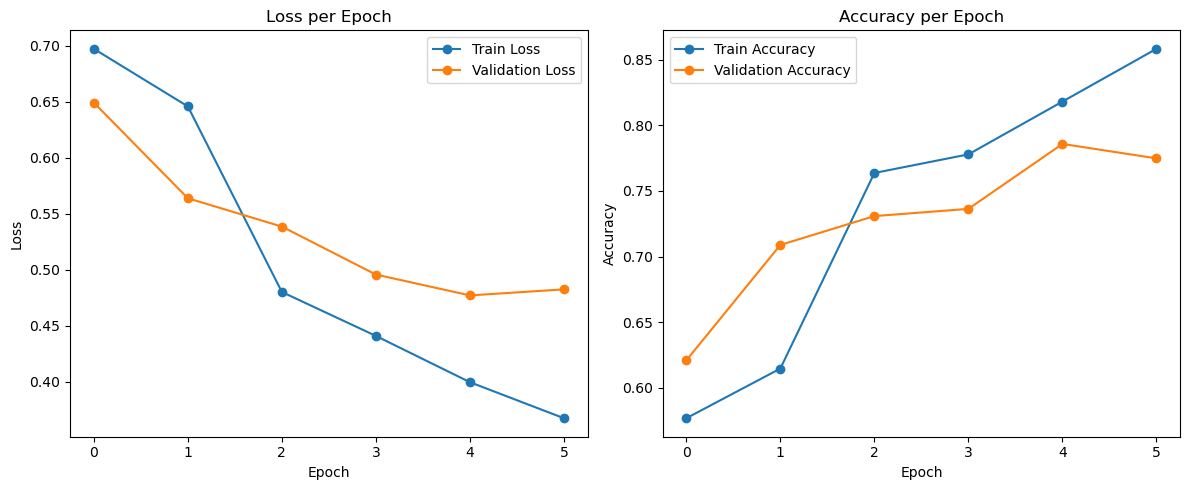

In [239]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# import torch
# import torch.nn.functional as F

# def generate_predictions(model, dataloader):
#     model.eval()
#     all_video_ids = []
#     all_exist_ids = []
#     all_probs = []
#     all_preds = []
#     all_labels = []
#     all_constant_column = []  # This will store the constant value "EXIST2025"
    
#     with torch.no_grad():
#         for batch in tqdm(dataloader, desc="Generating Predictions"):
#             batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
#             #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
#             inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
#             outputs = model(**inputs)
#             logits = outputs.logits
#             probs = F.softmax(logits, dim=1)  # Get probabilities from logits
#             preds = torch.argmax(probs, dim=1)  # Get predicted class
#             # Map the predictions to "YES" (1) or "NO" (0)
#             preds_mapped = ["YES" if pred >=0.5 else "NO" for pred in preds.cpu().numpy()]
            
#             constant_value = "EXIST2025"
#             constant_column = [constant_value] * len(preds_mapped)
            
#             all_exist_ids.extend(batch['exist_ids'])
#             all_video_ids.extend(batch['video_ids'])
#             all_probs.extend(probs.cpu().numpy())
#             all_preds.extend(preds_mapped)
#             all_labels.extend(batch['labels'].cpu().numpy())
#             all_constant_column.extend(constant_column)

#     return np.array(all_exist_ids), np.array(all_video_ids), np.array(all_probs), np.array(all_preds), np.array(all_labels), np.array(all_constant_column)


In [194]:
# for mps
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def generate_predictions(model, dataloader, device):
    model.eval()
    all_video_ids = []
    all_exist_ids = []
    all_probs = []
    all_preds = []
    all_labels = []
    all_constant_column = []  # This will store the constant value "EXIST2025"
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Predictions"):
            # Move tensor inputs to device (e.g., mps, cuda, cpu)
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            
            # Remove non-model inputs from batch
            inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
            
            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits
            
            # Calculate probabilities and move to CPU before numpy conversion
            probs = F.softmax(logits, dim=1).cpu()
            
            # Get predicted class indices and move to CPU
            preds = torch.argmax(probs, dim=1).cpu()
            
            # Map predictions to "YES" or "NO" based on predicted class (assuming class 1 = YES)
            preds_mapped = ["YES" if pred.item() == 1 else "NO" for pred in preds]
            
            # Prepare constant column
            constant_value = "EXIST2025"
            constant_column = [constant_value] * len(preds_mapped)
            
            # Append results - ensure all tensors are moved to CPU before numpy conversion
            # all_exist_ids.extend(batch['exist_ids'])
            # all_video_ids.extend(batch['video_ids'])

            all_exist_ids.extend(
                [x.item() if isinstance(x, torch.Tensor) else x for x in batch['exist_ids']]
            )
            all_video_ids.extend(
                [x.item() if isinstance(x, torch.Tensor) else x for x in batch['video_ids']]
            )
            all_probs.extend(probs.numpy())  # Already on CPU
            all_preds.extend(preds_mapped)
            all_labels.extend(batch['labels'].cpu().numpy())
            all_constant_column.extend(constant_column)

    # Convert lists to numpy arrays, ensuring all tensors are on CPU first
    return (
        np.array(all_exist_ids),
        np.array(all_video_ids),
        np.array(all_probs),
        np.array(all_preds),
        np.array(all_labels),
        np.array(all_constant_column)
    )


In [49]:
exist_ids, video_ids, probs, preds, labels, titles = generate_predictions(model, train_loader, device=device)

test_acc = accuracy_score(labels, preds)

preds_binary = [1 if p == "YES" else 0 for p in preds]
test_f1 = f1_score(labels, preds_binary, average="macro")

print(f"Train Accuracy: {test_acc:.4f}")
print(f"Train Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "test_case": titles,
    "id": exist_ids,
    "value": preds
})

df.to_csv("text_train_predictions.csv", index=False)
print("Saved predictions to text_train_predictions.csv")



Generating Predictions: 100%|██████████| 37/37 [01:04<00:00,  1.75s/it]

Train Accuracy: 0.0000
Train Macro F1 Score: 0.8805
Saved predictions to text_train_predictions.csv


In [195]:
exist_ids, video_ids, probs, preds, labels, titles = generate_predictions(model, test_loader, device=device)

preds_binary = [1 if p == "YES" else 0 for p in preds]
test_acc = accuracy_score(labels, preds_binary)
preds_binary = [1 if p == "YES" else 0 for p in preds]
test_f1 = f1_score(labels, preds_binary, average="macro")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "test_case": titles,
    "id": exist_ids,
    "value": preds
})

df.to_csv("text_test_predictions.csv", index=False)
print("Saved predictions to text_test_predictions.csv")

Generating Predictions: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]

Test Accuracy: 0.6881
Test Macro F1 Score: 0.6859
Saved predictions to text_test_predictions.csv


In [52]:
exist_ids, video_ids, probs, preds, labels, titles = generate_predictions(model, val_loader,device=device)

test_acc = accuracy_score(labels, preds)
preds_binary = [1 if p == "YES" else 0 for p in preds]
test_f1 = f1_score(labels, preds_binary, average="macro")

print(f"Val Accuracy: {test_acc:.4f}")
print(f"Val Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "test_case": titles,
    "id": exist_ids,
    "value": preds
})

df.to_csv("text_val_predictions.csv", index=False)
print("Saved predictions to text_val_predictions.csv")

Generating Predictions: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]

Val Accuracy: 0.0000
Val Macro F1 Score: 0.6814
Saved predictions to text_val_predictions.csv


In [17]:
# Save just the model's state dict (weights)
torch.save(model.state_dict(), "model_weights.pt")


In [8]:
# Recreate the model architecture first
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

# Load the saved weights
model.load_state_dict(torch.load("model_weights.pt", map_location=device))

# Move to device
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3761075/2181143520.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [ ]:
#The code below is for search grid which was used to decide the hyperparameters values
import itertools

# Define your hyperparameter search space
param_grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5, 2e-6],
    "batch_size": [8, 16],
    "weight_decay": [0.0, 0.01],
    "num_frozen_layers": [0, 6, 12, 18, 20]  # NEW!
}

# Create all combinations
param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

best_val_acc = 0
best_params = None

for param_values in param_combinations:
    params = dict(zip(param_names, param_values))
    print(f"\nTraining with parameters: {params}")

    # Rebuild model and optimizer each time
    model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)
    model.to(device)

    # --- Freeze Layers ---
    if params["num_frozen_layers"] > 0:
        for idx, layer in enumerate(model.roberta.encoder.layer):
            if idx < params["num_frozen_layers"]:
                for param in layer.parameters():
                    param.requires_grad = False
        print(f"✅ Froze first {params['num_frozen_layers']} layers.")

    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=params["learning_rate"], 
                                  weight_decay=params["weight_decay"])

    # Rebuild loaders if batch_size changes
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

    # --- Training ---
    for epoch in range(2):  # Short training for search
        model.train()
        for batch in train_loader:
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k != "video_ids"}

            outputs = model(**inputs)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # --- Validation ---
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k != "video_ids"}

            outputs = model(**inputs)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch['labels'].cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params

print(f"\n Best Validation Accuracy: {best_val_acc:.4f}")
print(f" Best Parameters: {best_params}")



Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.6308

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.6718

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6410

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6769

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6718

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7128

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7179

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.7026

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6872

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6256

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7128

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.6513

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6051

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6103

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.5128

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.6308

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.5795

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6308

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.5744

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7231

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6974

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6718

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7436

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6821

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6667

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6974

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7077

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7179

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.5744

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6615

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6667

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.6821

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7026

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6000

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.5487

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.4513

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.7282

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7282

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7077

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.7231

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6462

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6564

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.6308

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.7231

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6718

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.5538

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7333

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
